In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import matplotlib

In [27]:
def getfullYears(date):
    date=str(date)
    return int(date.split("-")[0])+(float(date.split("-")[1])/12)
    
print getfullYears('2008-02-01')

2008.16666667


In [28]:
df = pd.read_csv('../data/aden_golfe_matrix_global.csv',sep=';')
print df.head()
listDate = df.apply(lambda row: datetime.datetime.strptime(row['date'], "%Y-%m-%d"), axis=1)
df['date']=listDate
df['Full_Years'] = df.apply(lambda row: getfullYears(row['date']), axis=1)
df['count'] = df.apply(lambda row: row['Attempted']+row['Boarded']+row['Fired upon']+row['Hijacked'], axis=1)
df=df.set_index('date')
print df.head()

df_global=df['count']
df_type=df[['Attempted' , 'Boarded' , 'Fired upon' , 'Hijacked']]

   Attempted  Boarded  Fired upon  Hijacked        date
0          0        0           0         0  2008-01-01
1          0        0           1         1  2008-02-01
2          1        1           1         0  2008-03-01
3          1        0           3         2  2008-04-01
4          2        0           2         2  2008-05-01
            Attempted  Boarded  Fired upon  Hijacked   Full_Years  count
date                                                                    
2008-01-01          0        0           0         0  2008.083333      0
2008-02-01          0        0           1         1  2008.166667      2
2008-03-01          1        1           1         0  2008.250000      3
2008-04-01          1        0           3         2  2008.333333      6
2008-05-01          2        0           2         2  2008.416667      6


In [29]:
# Time series prediction : version 1

In [30]:
def sub_plot_data(df, title="Number of attacks"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(subplots=True,title=title, fontsize=12,figsize=(12,12))
    plt.show()
    
def plot_data(df, title="Number of attacks"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12,figsize=(12,12))
    ax.set_xlabel("Date")
    ax.set_ylabel("Nb attacks")
    plt.show()



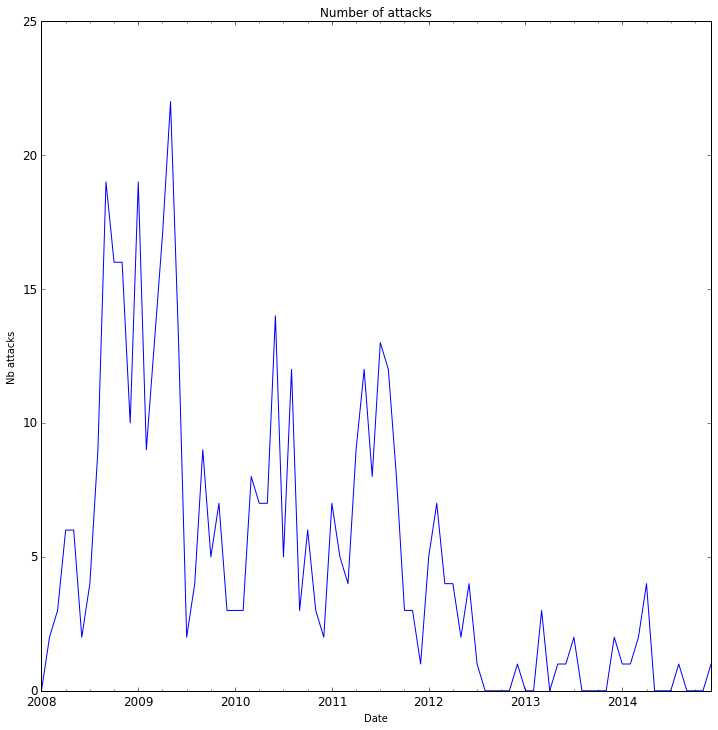

In [31]:
plot_data(df_global)

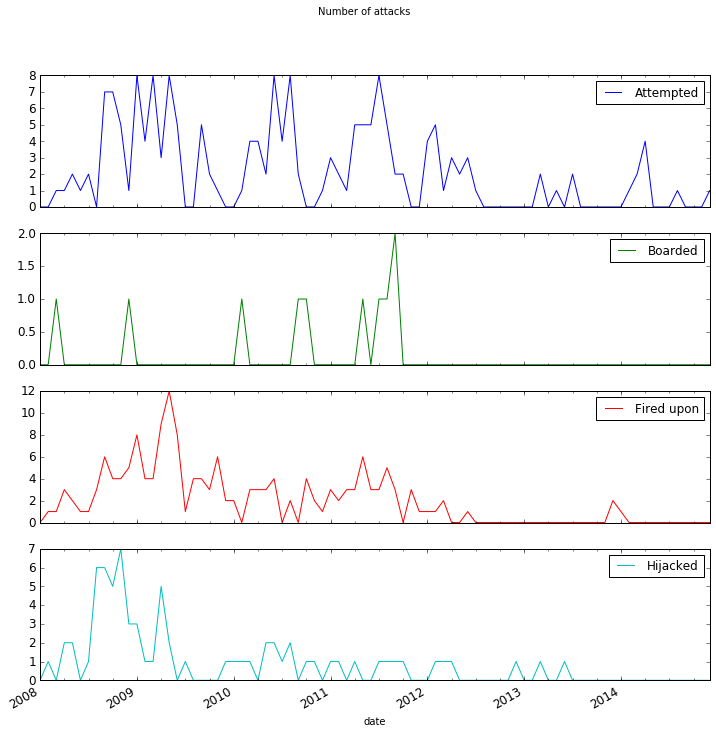

In [32]:
sub_plot_data(df_type)

In [33]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

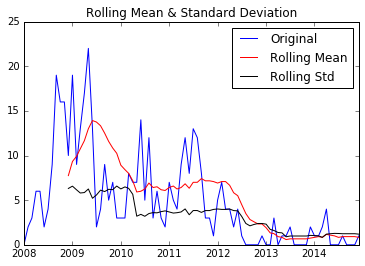

Results of Dickey-Fuller Test:
Test Statistic                 -2.660536
p-value                         0.081120
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (5%)            -2.897490
Critical Value (1%)            -3.512738
Critical Value (10%)           -2.585949
dtype: float64


In [34]:
test_stationarity(df_global)

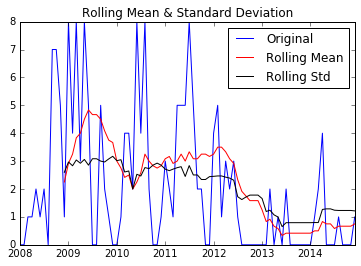

Results of Dickey-Fuller Test:
Test Statistic                 -3.744196
p-value                         0.003533
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (5%)            -2.897490
Critical Value (1%)            -3.512738
Critical Value (10%)           -2.585949
dtype: float64


In [35]:
test_stationarity(df_type['Attempted'])

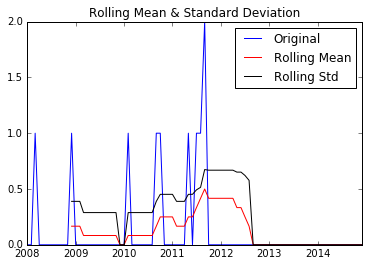

Results of Dickey-Fuller Test:
Test Statistic                -6.905132e+00
p-value                        1.252896e-09
#Lags Used                     0.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (5%)           -2.897048e+00
Critical Value (1%)           -3.511712e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


In [36]:
test_stationarity(df_type['Boarded'])

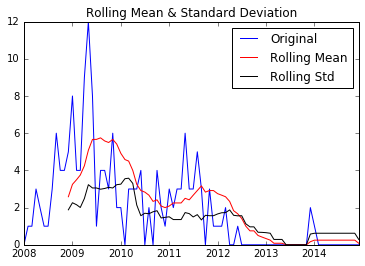

Results of Dickey-Fuller Test:
Test Statistic                 -1.816242
p-value                         0.372428
#Lags Used                      7.000000
Number of Observations Used    76.000000
Critical Value (5%)            -2.900395
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
dtype: float64


In [37]:
test_stationarity(df_type['Fired upon'])

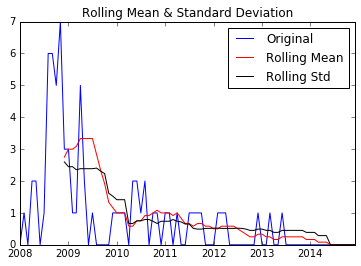

Results of Dickey-Fuller Test:
Test Statistic                 -3.648491
p-value                         0.004899
#Lags Used                      8.000000
Number of Observations Used    75.000000
Critical Value (5%)            -2.900925
Critical Value (1%)            -3.520713
Critical Value (10%)           -2.587781
dtype: float64


In [38]:
test_stationarity(df_type['Hijacked'])

In [41]:
def computedailyreturn(df):
    """ compute and return the daily return value"""
    dailyreturn=(df /df.shift(1))-1
    #print dailyreturn
    #dailyreturn.ix[0,:]=0
    return dailyreturn

In [53]:
daily=computedailyreturn(df_global)

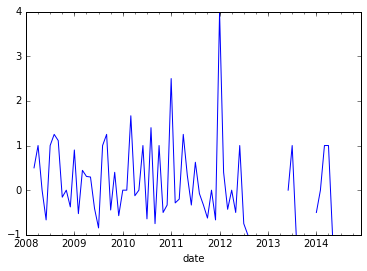

In [54]:
daily.plot()

In [44]:
# Time Series version 2

In [45]:
to_forecast = df_global.values

to_forecast_Attempted = df_type['Attempted'].values
to_forecast_Boarded = df_type['Boarded'].values
to_forecast_Fired = df_type['Fired upon'].values
to_forecast_Hijacked = df_type['Hijacked'].values

dates = df['Full_Years'].values
print df.head(5)

            Attempted  Boarded  Fired upon  Hijacked   Full_Years  count
date                                                                    
2008-01-01          0        0           0         0  2008.083333      0
2008-02-01          0        0           1         1  2008.166667      2
2008-03-01          1        1           1         0  2008.250000      3
2008-04-01          1        0           3         2  2008.333333      6
2008-05-01          2        0           2         2  2008.416667      6


In [46]:
import numpy as np

def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, shape=shape, strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 13   # number of previous observations to use
h = 1  # forecast horizon
X,y = organize_data(to_forecast, k, h)

X_Attempted , y_Attempted = organize_data(to_forecast_Attempted, k, h)
X_Boarded , y_Boarded = organize_data(to_forecast_Boarded, k, h)
X_Fired , y_Fired = organize_data(to_forecast_Fired, k, h)
X_Hijacked , y_Hijacked = organize_data(to_forecast_Hijacked, k, h)


In [47]:
m = 55 # number of samples to take in account
def getPrediction(X,y):
    #regressor = LinearRegression(normalize=True)
    regressor=RandomForestRegressor()
    regressor.fit(X[:m], y[:m])
    predictions=regressor.predict(X)
    predictionError=regressor.predict(X[m:])
    predictions[predictions < 0] = 0
    
    return predictions,predictionError

predictionGlobal,predictionErrorGlobal=getPrediction(X,y)

prediction_Attempted , predictionError_Attempted = getPrediction(X_Attempted,y_Attempted )
prediction_Boarded , predictionError_Boarded = getPrediction(X_Boarded,y_Boarded)
predictionGlobal_Fired , predictionError_Fired = getPrediction(X_Fired,y_Fired)
predictionGlobal_Hijacked, predictionError_Hijacked = getPrediction(X_Hijacked,y_Hijacked)

In [48]:
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    ypred[ypred < 0] = 0
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print 'The error is %0.2f%%' % mape(predictionErrorGlobal,y[m:])

print 'The error is %0.2f%%' % mape(prediction_Attempted,y_Attempted[m:])
print 'The error is %0.2f%%' % mape(predictionError_Boarded,y_Boarded[m:])
print 'The error is %0.2f%%' % mape(predictionError_Fired,y_Fired[m:])
print 'The error is %0.2f%%' % mape(predictionError_Hijacked,y_Hijacked[m:])

The error is 54.29%
The error is 45.00%
The error is nan%
The error is 95.00%
The error is nan%


/Users/romainphilippe/app/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 16
/Users/romainphilippe/app/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


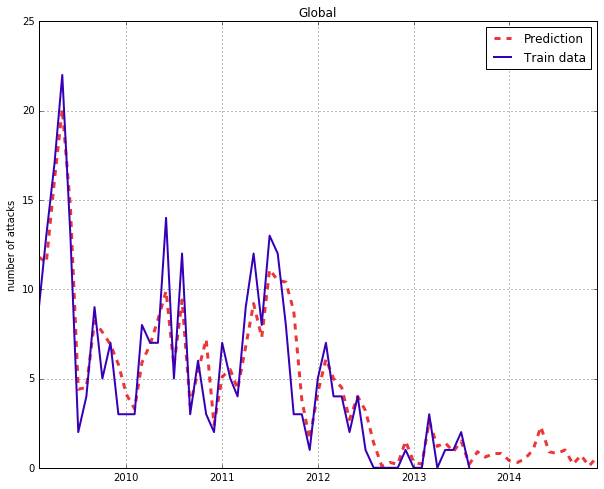

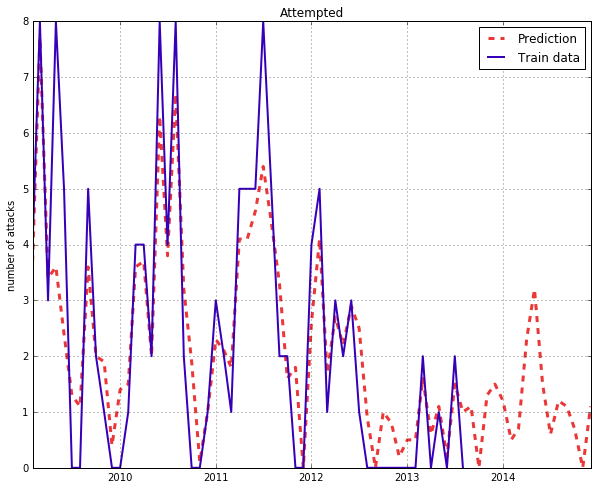

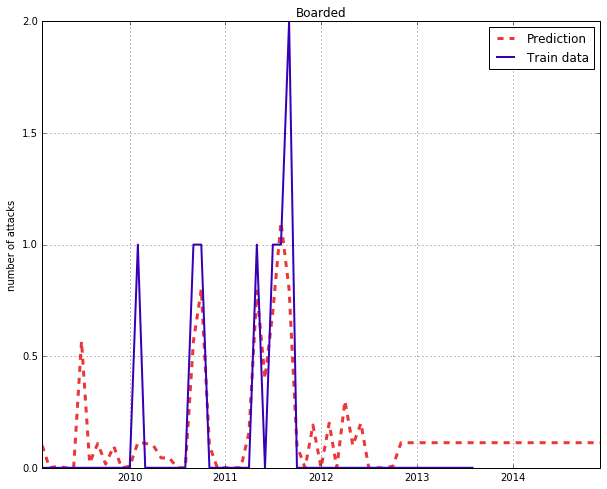

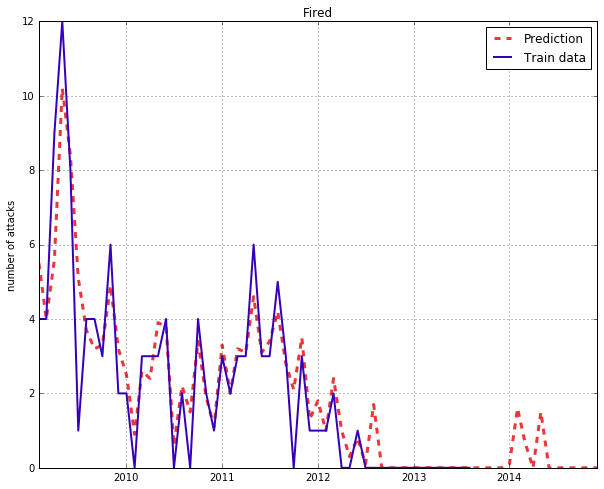

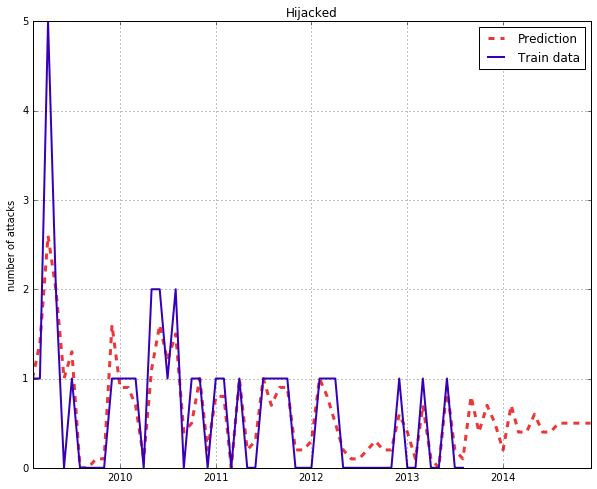

In [50]:
def plotPrediction(prediction,y,title):
    plt.figure(figsize=(10,8))
    plt.plot(listDate[k:],prediction, '--', color='#EB3737', linewidth=3, label='Prediction')
    plt.plot(listDate[k:k+m],y[:m], label='Train data', color='#3700B8', linewidth=2)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.ylabel('number of attacks')
    plt.show()

plotPrediction(predictionGlobal,y,"Global")

plotPrediction(prediction_Attempted ,y_Attempted,"Attempted")
plotPrediction(prediction_Boarded,y_Boarded,"Boarded")
plotPrediction(predictionGlobal_Fired,y_Fired,"Fired")
plotPrediction(predictionGlobal_Hijacked,y_Hijacked,"Hijacked")

In [51]:
dfTest = pd.DataFrame(index=listDate)
prediction=np.concatenate([np.repeat(np.NAN,k),predictions])
true_value=np.concatenate([np.repeat(np.NAN,k),y[:m],np.repeat(np.NAN,len(listDate)-(k+m))])
dfTest['prediction']=prediction
dfTest['True']=true_value

NameError: name 'predictions' is not defined

In [52]:
dfTest.plot(figsize=(12,12),grid=True)

TypeError: Empty 'DataFrame': no numeric data to plot